## CX4240 project

## Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning

# Classifications


In [15]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.stats as stat
import sklearn.preprocessing as pre
import glob
import mahotas as mt
import pywt
import seaborn as sns
import pandas as pd
import csv 
import matplotlib as mpl
import time

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from mlens.ensemble import SuperLearner
from mlens.metrics import make_scorer


%matplotlib inline


## Load data

In [17]:
train_df = pd.read_csv('Data/RF_train_data.csv')
train = pd.DataFrame.as_matrix(train_df)
test = pd.DataFrame.as_matrix(pd.read_csv('Data/RF_test_data.csv'))
train_data = train[:,2:]
label_train = np.array(train[:,1], dtype=int)
test_data = test[:,2:]
label_test = np.array(test[:,1], dtype=int)
features = list(train_df.columns[2:]) 
print(np.shape(train_data))
print(np.shape(test_data))
n_ALL = 7272
n_hem = 3389
features

(10661, 16)
(1867, 16)


C:\Users\1000j\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\1000j\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


['Cell Size',
 'Perimeter',
 'Intensity Variance',
 'Red Mean',
 'Value Mean',
 'Hue Mean',
 'Saturation Mean',
 'Blue Mean',
 'Green Mean',
 'Form Factor',
 'Intensity Mean',
 'Wavelet Approximation Mean',
 'Haralick Sum Average',
 'Boundary Roughness Variance',
 'Haralick Inverse Difference Moment',
 'Haralick Difference Variance']

# Classification

In [39]:
def accuracy(label, pred):
    """
    Calculates true positive, false positive, false negative, true negative, and Accuracy
    arg:
        label: Nx1 vector of true label
        pred: Nx1 vector of predicted labels
    return: 
        accuracy
    """
    TP,FP,TN,FN = 0,0,0,0
    for i in range(len(pred)):
        if (pred[i]==1 and label[i]==1):
            TP = TP + 1
        elif (pred[i]==1 and label[i]==0):
            FP = FP + 1
        elif (pred[i]==0 and label[i]==0):
            TN = TN + 1
        elif (pred[i]==0 and label[i]==1):
            FN = FN + 1
        else:
            print('ERROR: Different values')
    print('True Positive:  ',TP)
    print('False Positive: ',FP)
    print('True Negative:  ',TN)
    print('False Negative: ',FN)
    return (TP+TN)/(TP+TN+FP+FN)


def get_errors(prediction, label):
    """
    args:
        label: numpy array of ground truth (1 is positive, 0 is negative)
        prediction: numpy array of prediction
    returns:
        false_positive: integer of occurences of false positives
        false_negative: integer of occurences of false negatives
        true_positive: integer of occurences of true positives
        true_negative: integer of occurences of true negatives
    """
    diff = label - prediction
    false_positive = np.count_nonzero(diff == -1)
    false_negative = np.count_nonzero(diff == 1)
    total_positive = np.sum(label)
    total_negative = int(len(label) - total_positive)
    true_positive = int(total_positive - false_negative)
    true_negative = total_negative - false_positive
    accuracy = np.round((true_positive + true_negative) / 
                                       (total_positive + total_negative), decimals=3)
    print('True Positive:  ',true_positive)
    print('False Positive: ',false_positive)
    print('True Negative:  ',true_negative)
    print('False Negative: ',false_negative)
    print('Accuracy:       ',accuracy)
    return accuracy

## Support Vector Machine (SVM)

In [5]:
# SVM
# Tuning the hyperparameters
param_grid =  {'C': [7], 'gamma': [5], 'kernel': ['rbf'], 'probability':[True]}
SV_clf = GridSearchCV(svm.SVC(), param_grid, cv=5)
t0 = time.time()
SV_clf.fit(train_data, label_train)
svc_fit = time.time() - t0
print("SVM gamma and C selected and model fitted in %.2f s"
      % svc_fit)


# save the best hyperparameters
svm_c, svm_gamma = SV_clf.best_estimator_.C, SV_clf.best_estimator_.gamma

print('best score:', SV_clf.best_score_)                               
print('best C value:', svm_c)
print('best gamma value:', svm_gamma)


SVM gamma and C selected and model fitted in 46.73 s
best score: 0.857424256636338
best C value: 7
best gamma value: 5


In [57]:
# see how it works on the training data
print('SVM Results')
print('-------------------------')
print('Training Data:')
train_predictions = SV_clf.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = SV_clf.predict(test_data)
SVM_accuracy = get_errors(test_predictions, label_test)

accuracies = [SVM_accuracy]

SVM Results
-------------------------
Training Data:
True Positive:   7009
False Positive:  849
True Negative:   2540
False Negative:  263
Accuracy:        0.896
 
Test Data:
True Positive:   1095
False Positive:  370
True Negative:   278
False Negative:  124
Accuracy:        0.735


## Random Forest (RF)

In [7]:
# Tuning the hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
RF_clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
RF_clf.fit(train_data, label_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 29.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [58]:
# print optomized parameters
print(RF_clf.best_estimator_)


# see how it works on the training data
print('RF Results')
print('-------------------------')
print('Training Data:')
train_predictions = RF_clf.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = RF_clf.predict(test_data)
RF_accuracy = get_errors(test_predictions, label_test)

accuracies.append(RF_accuracy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
RF Results
-------------------------
Training Data:
True Positive:   7272
False Positive:  0
True Negative:   3389
False Negative:  0
Accuracy:        1.0
 
Test Data:
True Positive:   1115
False Positive:  381
True Negative:   267
False Negative:  104
Accuracy:        0.74


In [59]:
# more conservative rf
rf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=75, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# fit
rf2.fit(train_data, label_train)


# see how it works on the training data
print('RF Results')
print('-------------------------')
print('Training Data:')
train_predictions = rf2.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = rf2.predict(test_data)
RF2_accuracy = get_errors(test_predictions, label_test)

accuracies.append(RF2_accuracy)

RF Results
-------------------------
Training Data:
True Positive:   7220
False Positive:  334
True Negative:   3055
False Negative:  52
Accuracy:        0.964
 
Test Data:
True Positive:   1123
False Positive:  393
True Negative:   255
False Negative:  96
Accuracy:        0.738


## K Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [24]:
"""
Find best K values using cross validation
"""
def k_fold_test(train_data, train_label, train_index, test_index, k_value):
    KNN = KNeighborsClassifier(n_neighbors = k_value, weights="uniform", algorithm="brute") 
    KNN.fit(train_data[train_index,:], train_label[train_index])
    mean_accuracy_current_fold = KNN.score(train_data[test_index,:], train_label[test_index])
    return mean_accuracy_current_fold

def k_value_use_k_fold(train_data, train_label, k_value, kfold_nsplit):
    all_mean_accuracy = []
    kf = KFold(n_splits = kfold_nsplit, shuffle = False)
    for train_index, test_index in kf.split(train_data):
        mean_accuracy_current_fold = k_fold_test(train_data, train_label, train_index, test_index, k_value)
        all_mean_accuracy.append(mean_accuracy_current_fold)
    average_accuracy = np.round(np.mean(np.array(all_mean_accuracy)), decimals=4)
    print("{} \t {}".format(k_value, average_accuracy))
    return average_accuracy

K val 	 Avg. Accuracy
--------------------------
4 	 0.778
6 	 0.7993
8 	 0.8078
9 	 0.8188
10 	 0.8126
30 	 0.8182
50 	 0.8144
90 	 0.8101
100 	 0.8096
150 	 0.8045
200 	 0.8012


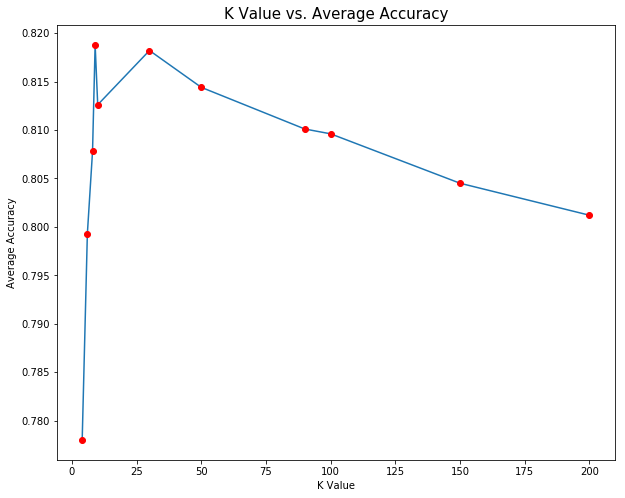

In [37]:
"""
Actual Testing
"""
number_of_splits = 10
k_value_list = [4,6,8,9,10, 30, 50, 90, 100, 150, 200]

print('K val \t Avg. Accuracy')
print('--------------------------')
test_tuple_list = []
for k_value in k_value_list:
    average_accuracy = k_value_use_k_fold(train_data, label_train, k_value, number_of_splits)
    test_tuple_list.append((average_accuracy, k_value))
    
x = [x[1] for x in test_tuple_list]
y = [x[0] for x in test_tuple_list]
plt.figure(figsize=(10,8))
plt.plot(x,y)
plt.plot(x,y,'or')
plt.title("K Value vs. Average Accuracy", fontsize=15)
plt.xlabel("K Value", fontsize=10)
plt.ylabel("Average Accuracy", fontsize=10)
plt.show()

test_tuple_list.sort(reverse = True)
best_k_value = test_tuple_list[0][1]

In [60]:
# Use the best K_value

print("Best K Value is {}".format(best_k_value))
print(' ')
KNN_clf = KNeighborsClassifier(n_neighbors = best_k_value, weights="uniform", algorithm="brute")


# train and predict
KNN_clf.fit(train_data, label_train)
KNN_train_pred = KNN_clf.predict(train_data)
KNN_test_pred = KNN_clf.predict(test_data)


# print results
# train results
print('KNN Results')
print('-------------------------')
print('Training Data')
get_errors(KNN_train_pred, label_train)

# test results
print(' ')
print('Test Data')
KNN_accuracy = get_errors(KNN_test_pred, label_test)

accuracies.append(KNN_accuracy)

Best K Value is 9
 
KNN Results
-------------------------
Training Data
True Positive:   6933
False Positive:  925
True Negative:   2464
False Negative:  339
Accuracy:        0.881
 
Test Data
True Positive:   1116
False Positive:  392
True Negative:   256
False Negative:  103
Accuracy:        0.735


## Ensemble

In [49]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#import xgboost as xgb
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score

seed = 2034
np.random.seed(seed)

In [61]:
# Max Voting
# create models with the optomizal hyperparameters from above
svc = svm.SVC(C=svm_c, gamma=svm_gamma, kernel='rbf', probability=True)
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
knn = KNeighborsClassifier(n_neighbors = best_k_value, weights="uniform", algorithm="brute")
ests = [('svc', svc), ('rf', rf), ('knn', knn)]

# create the max-vote classifier
MV_clf = VotingClassifier(estimators=ests, voting='soft')

# train and predict
MV_clf.fit(train_data, label_train)
mv_train_pred = MV_clf.predict(train_data)
mv_test_pred = MV_clf.predict(test_data)


# print results
# train results
print('Max Voting Results')
print('-------------------------')
print('Train Data')
get_errors(mv_train_pred, label_train)

# test results
print(' ')
print('Test Data')
Voting_accuracy = get_errors(mv_test_pred, label_test)

accuracies.append(Voting_accuracy)
accuracies

Max Voting Results
-------------------------
Train Data
True Positive:   7116
False Positive:  639
True Negative:   2750
False Negative:  156
Accuracy:        0.925
 
Test Data
True Positive:   1116
False Positive:  383
True Negative:   265
False Negative:  103
Accuracy:        0.74


[0.735, 0.74, 0.738, 0.735, 0.74]

In [ ]:
# Stacking
ensemble = SuperLearner(scorer=accuracy_score, random_state=seed, verbose=2)

# Build the first layer
ensemble.add([KNeighborsClassifier(), svm.SVC()])

# Attach the final meta estimator
ensemble.add_meta(LogisticRegression())

# Fit ensemble
ensemble.fit(train_data, label_train)

# Predict train data
preds = ensemble.predict(train_data)

### ROC Curve

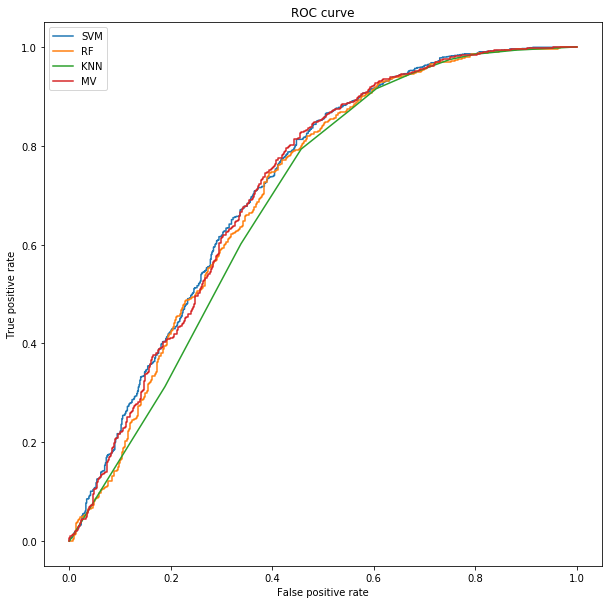

In [22]:
from sklearn.metrics import roc_curve
SVM_prob = SV_clf.predict_proba(test_data)[:,1]
FPR_SVM, TPR_SVM, _ = roc_curve(label_test, SVM_prob)
RF_prob = rf2.predict_proba(test_data)[:,1]
FPR_RF, TPR_RF, _ = roc_curve(label_test, RF_prob)
KNN_prob = KNN_clf.predict_proba(test_data)[:,1]
FPR_KNN, TPR_KNN, _ = roc_curve(label_test, KNN_prob)
MV_prob = MV_clf.predict_proba(test_data)[:,1]
FPR_MV, TPR_MV, _ = roc_curve(label_test, MV_prob)

"""
Bag_prob = Bag.predict_proba(test_data)[:,1]
FPR_Bag, TPR_Bag, _ = roc_curve(label_test, Bag_prob)
Ada_prob = Ada.predict_proba(test_data)[:,1]
FPR_Ada, TPR_Ada, _ = roc_curve(label_test, Ada_prob)
SGB_prob = SGB.predict_proba(test_data)[:,1]
FPR_SGB, TPR_SGB, _ = roc_curve(label_test, SGB_prob)
XGB_prob = XGB.predict_proba(test_data)[:,1]
FPR_XGB, TPR_XGB, _ = roc_curve(label_test, XGB_prob)
Vot_prob = Voting.predict_proba(test_data)[:,1]
FPR_Vot, TPR_Vot, _ = roc_curve(label_test, Vot_prob)
"""


plt.figure(1, figsize = (10,10))
plt.plot(FPR_SVM, TPR_SVM, label='SVM')
plt.plot(FPR_RF, TPR_RF, label='RF')
plt.plot(FPR_KNN, TPR_KNN, label='KNN')
plt.plot(FPR_MV, TPR_MV, label='MV')

"""
plt.plot(FPR_Bag, TPR_Bag, label='Bag')
plt.plot(FPR_Ada, TPR_Ada, label='Ada')
plt.plot(FPR_SGB, TPR_SGB, label='SGB')
plt.plot(FPR_XGB, TPR_XGB, label='XGB')
plt.plot(FPR_Vot, TPR_Vot, label='Voting')
"""
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

No handles with labels found to put in legend.


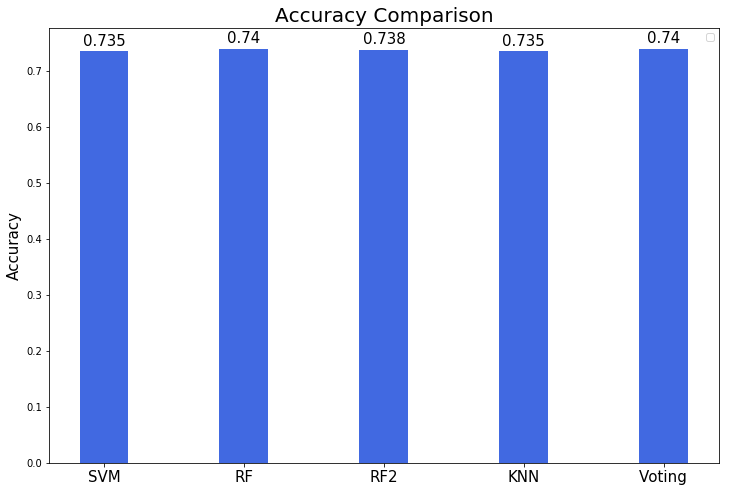

In [87]:
# Plot accuracies

models = ['SVM', 'RF', 'RF2', 'KNN', 'Voting']
x = np.arange(len(models))
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 8))
rects = ax.bar(x, accuracies, width, color='royalblue')
ax.set_title("Accuracy Comparison", fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=15)
ax.legend()
for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
              xy=(rect.get_x() + rect.get_width() / 2, height),
              xytext=(0, 3),  
              textcoords="offset points",
              ha='center', va='bottom',fontsize = 15)